# Continuos Regression with *KQM*

### Concept

We will set `output_dim = 2` so that the model would predict a $2-\dim$ vector: $[cos^2\theta, sin^2\theta]$, and we will actually do the inference over $\theta$. Therefore, the range of the output variable must be within $[0, \pi/2]$.

### Import libraries

In [30]:
import re

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn import metrics
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.layers import Input, Dense, Dropout, Activation
from keras.models import Model
from keras import optimizers
from keras import losses
import concurrent.futures
from itertools import product
from keras.layers import Input, Dense, Reshape
import kqm
import itertools
print("Tensorflow version:",tf.__version__)

2024-11-08 12:02:56.915262: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-08 12:02:57.050852: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 12:02:57.050900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 12:02:57.073277: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 12:02:57.126746: I tensorflow/core/platform/cpu_feature_guar

Tensorflow version: 2.15.0


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2024-11-08 12:03:04.466718: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-08 12:03:04.541659: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-08 12:03:04.541814: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Check GPU

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Nov  8 12:03:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A2000 8GB Lap...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8               3W /  40W |      9MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Loading Dataset

## Diabetes

In [10]:
from sklearn import datasets
 
X,y= datasets.load_diabetes(return_X_y = True)
y = y.astype(float).reshape(-1, 1)

## 70% - 30% Hold Out and MinMax Scaling for `y` 

In [12]:
from sklearn.model_selection import train_test_split

# Split data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

scaler_x = StandardScaler()
scaler_x.fit(X_train)
X_train = scaler_x.transform(X_train)
X_test = scaler_x.transform(X_test)

scaler = MinMaxScaler(feature_range=(0.2, np.pi/2-0.2))
scaler.fit(y_train)
y_train = scaler.transform(y_train)
#y_test = scaler.transform(y_test))
y_train = np.asarray(y_train).reshape(-1)
y_test = np.asarray(y_test).reshape(-1)

print(f"Training features size: {X_train.shape}")
print(f"Training labels size: {y_train.shape}")

Training set size: (309, 10)
Test set size: (133, 10)
Training features size: (309, 10)
Training labels size: (309,)


## Defining KQM-Model

In [14]:
n_comp=32

In [15]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(X_train.shape[1],),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            #self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        probs = kqm.dm2discrete(rho_y)
        probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        theta = tf.acos(probs_0_sqrt)
        return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

## Training and Test

2024-11-08 12:08:09.587873: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-08 12:08:09.588072: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-08 12:08:09.588152: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

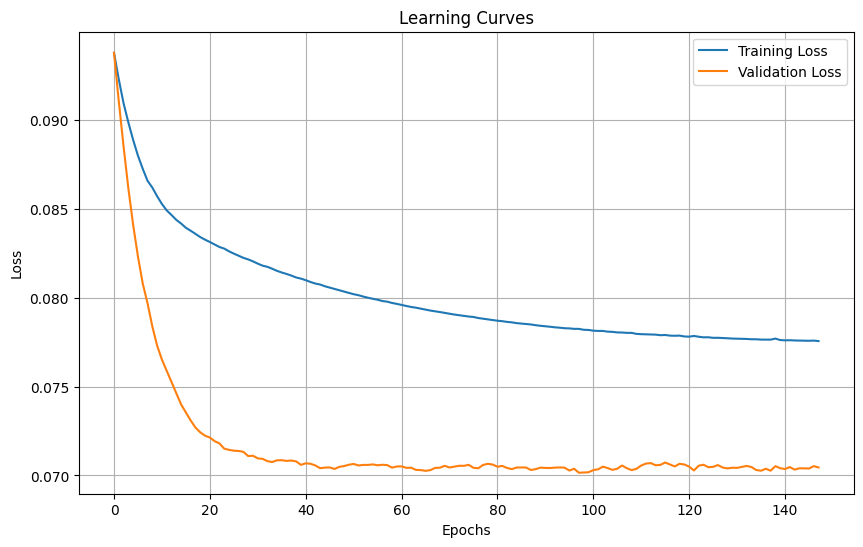

MAE = 64.93764593368186
MSE = 5504.655967108849
R^2 = -0.019700285703195597


In [16]:
stoppping_a = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=50,
                        verbose=0,
                        mode="min",
                        baseline=None,
                        restore_best_weights=True,
                        start_from_epoch=0,
                    )

kernel = 'rbf'
learning_rate = 0.001
encoding_dim = X_train.shape[1]
num_hidden_layer = 1

kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
kqm_model.encoder.trainable = True

kqm_model.kqm_class_encoded.compile(
          optimizer=optimizers.Adam(learning_rate=learning_rate),
          loss=losses.mse)

np.random.seed(42)
indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
selected_samples = X_train[indices]
kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
#kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))

history = kqm_model.kqm_class_encoded.fit(X_train, y_train,
          validation_split = 0.2,
          epochs=200,
          batch_size=32,
          verbose=0,
          callbacks=[stoppping_a])

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
print('MAE =',mean_absolute_error(y_test, y_pred))
print('MSE =',mean_squared_error(y_test, y_pred))
print('R^2 =',r2_score(y_test, y_pred))

# Initializing weights `c_y`

ok


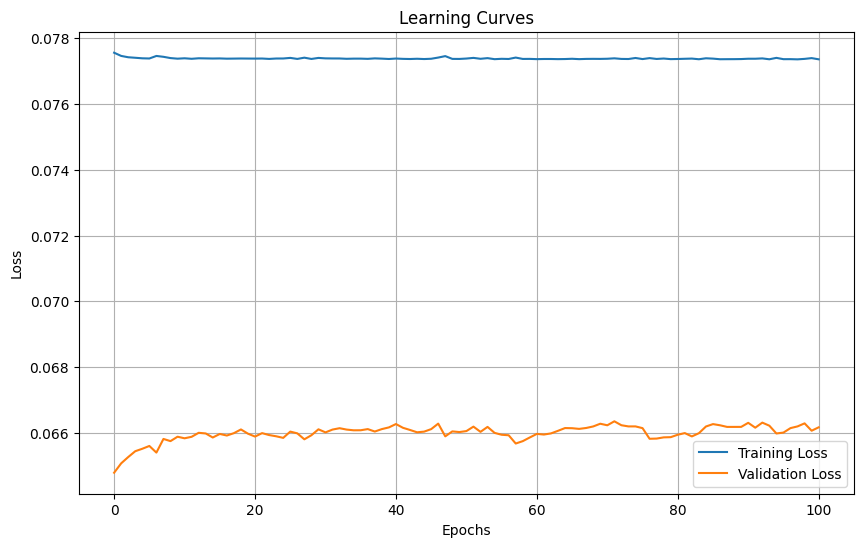

MAE = 64.57112075690937
MSE = 5462.678106739286
R^2 = -0.011924170998149908


In [17]:
stoppping_a = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=100,
                        verbose=0,
                        mode="min",
                        baseline=None,
                        restore_best_weights=True,
                        start_from_epoch=0,
                    )

kernel = 'rbf'
learning_rate = 0.001
encoding_dim = X_train.shape[1]
num_hidden_layer = 1

kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
kqm_model.encoder.trainable = True

kqm_model.kqm_class_encoded.compile(
          optimizer=optimizers.Adam(learning_rate=learning_rate),
          loss=losses.mse)

np.random.seed(42)
indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
selected_samples = X_train[indices]
selected_labels = y_train[indices]
cos_values = np.cos(selected_labels)
sin_values = np.sin(selected_labels)
kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
kqm_model.kqm_unit_encoded.c_y.assign(np.column_stack((cos_values, sin_values)))
print('ok')

history = kqm_model.kqm_class_encoded.fit(X_train, y_train,
          validation_split = 0.2,
          epochs=200,
          batch_size=32,
          verbose=0,
          callbacks=[stoppping_a])

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
print('MAE =',mean_absolute_error(y_test, y_pred))
print('MSE =',mean_squared_error(y_test, y_pred))
print('R^2 =',r2_score(y_test, y_pred))

In [18]:
y_pred

array([156.04567, 156.04567, 156.04567, 156.04567, 156.04567, 156.04567,
       156.04567, 156.04567, 156.04567, 156.04567, 156.04567, 156.04567,
       156.04567, 156.04567, 156.04567, 156.04567, 156.04567, 156.04567,
       156.04567, 156.04567, 156.04567, 156.04567, 156.04567, 156.04567,
       156.04567, 156.04567, 156.04567, 156.04567, 156.04567, 156.04567,
       156.04567, 156.04567, 156.04567, 156.04567, 156.04567, 156.04567,
       156.04567, 156.04567, 156.04567, 156.04567, 156.04567, 156.04567,
       156.04567, 156.04567, 156.04567, 156.04567, 156.04567, 156.04567,
       156.04567, 156.04567, 156.04567, 156.04567, 156.04567, 156.04567,
       156.04567, 156.04567, 156.04567, 156.04567, 156.04567, 156.04567,
       156.04567, 156.04567, 156.04567, 156.04567, 156.04567, 156.04567,
       156.04567, 156.04567, 156.04567, 156.04567, 156.04567, 156.04567,
       156.04567, 156.04567, 156.04567, 156.04567, 156.04567, 156.04567,
       156.04567, 156.04567, 156.04567, 156.04567, 

In [19]:
y_test

array([219.,  70., 202., 230., 111.,  84., 242., 272.,  94.,  96.,  94.,
       252.,  99., 297., 135.,  67., 295., 264., 170., 275., 310.,  64.,
       128., 232., 129., 118., 263.,  77.,  48., 107., 140., 113.,  90.,
       164., 180., 233.,  42.,  84., 172.,  63.,  48., 108., 156., 168.,
        90.,  52., 200.,  87.,  90., 258., 136., 158.,  69.,  72., 171.,
        95.,  72., 151., 168.,  60., 122.,  52., 187., 102., 214., 248.,
       181., 110., 140., 202., 101., 222., 281.,  61.,  89.,  91., 186.,
       220., 237., 233.,  68., 190.,  96.,  72., 153.,  98.,  37.,  63.,
       184., 144., 150., 280., 125.,  59.,  65., 281., 277., 167.,  90.,
        72., 178.,  88., 270., 101., 197.,  97.,  53.,  71., 262.,  52.,
       102., 166., 189., 173., 220., 206.,  97.,  60.,  61., 242., 121.,
       128., 104., 265., 132., 283., 174., 129., 257., 137.,  63.,  93.,
       232.])

# Hyper-parameter exploration

We are going to explore:
```
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']
```

In [20]:
# Defining hyperparams to explore
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']

# Some fixed hyper-params
encoding_dim = X_train.shape[1]
num_hidden_layer = 1
n_comp=32

# For saving:
best_model = None
best_hyperparameters = None

In [45]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(X_train.shape[1],),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            #self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        probs = kqm.dm2discrete(rho_y)
        probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        theta = tf.acos(probs_0_sqrt)
        return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

In [22]:
best_MSE = 1000

for lr, kernel in itertools.product(learning_rates, kernels):
    print(f"Running experiment with learning_rate={lr} and kernel={kernel}")

    stoppping_a = EarlyStopping(
                            monitor="val_loss",
                            min_delta=0,
                            patience=50,
                            verbose=0,
                            mode="min",
                            baseline=None,
                            restore_best_weights=True,
                            start_from_epoch=0,
                        )
    
    kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
    kqm_model.encoder.trainable = True
    
    kqm_model.kqm_class_encoded.compile(
              optimizer=optimizers.Adam(learning_rate=lr),
              loss=losses.mse)
    
    np.random.seed(42)
    indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
    selected_samples = X_train[indices]
    kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
    #kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))
    
    kqm_model.kqm_class_encoded.fit(X_train, y_train,
              validation_split = 0.2,
              epochs=200,
              batch_size=32,
              verbose=0,
              callbacks=[stoppping_a])
    
    y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
    print('MAE =',mean_absolute_error(y_test, y_pred))
    print('MSE =',mean_squared_error(y_test, y_pred))
    print('R^2 =',r2_score(y_test, y_pred))

    if mean_squared_error(y_test, y_pred) < best_MSE:
        best_MSE = mean_squared_error(y_test, y_pred)
        best_model = kqm_model
        best_hyperparameters = (lr, kernel)
        print("New best model")

print("Best hyper-parameters:", best_hyperparameters)

Running experiment with learning_rate=1e-05 and kernel=rbf
MAE = 70.74454515500176
MSE = 6498.00061674145
R^2 = -0.20371066329707577
Running experiment with learning_rate=1e-05 and kernel=cos
MAE = 70.47226778188146
MSE = 6446.061097212955
R^2 = -0.19408921861116735
Running experiment with learning_rate=5e-05 and kernel=rbf
MAE = 66.9541449295847
MSE = 5836.965136341898
R^2 = -0.08125831164222719
Running experiment with learning_rate=5e-05 and kernel=cos
MAE = 66.1248281378495
MSE = 5660.515797550423
R^2 = -0.04857226509310775
Running experiment with learning_rate=0.0001 and kernel=rbf
MAE = 65.58033958951333
MSE = 5595.119832405199
R^2 = -0.036458104872947095
Running experiment with learning_rate=0.0001 and kernel=cos
MAE = 65.29246761924342
MSE = 5529.320240549421
R^2 = -0.024269175534692655
Running experiment with learning_rate=0.0005 and kernel=rbf
MAE = 64.99391965937794
MSE = 5511.47343470255
R^2 = -0.0209631754631745
Running experiment with learning_rate=0.0005 and kernel=cos
MA

```
Running experiment with learning_rate=0.005 and kernel=rbf
MAE = 0.5405781868176582
MSE = 0.49454100299689785
R^2 = 0.32221229534881646
New best model
```

## Adding an Encoder

We are going to explore:
```
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']
encoding_dim = [6, 8, 16]
num_hidden_layer = [1,2]
```

In [24]:
# Defining hyperparams to explore
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']
encoding_dim = [16, 32, 64]
num_hidden_layers = [1,2]

# Some fixed hyper-params

n_comp=32

# For saving:
best_model = None
best_hyperparameters = None

In [25]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(X_train.shape[1],),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            #self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        probs = kqm.dm2discrete(rho_y)
        probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        theta = tf.acos(probs_0_sqrt)
        return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

In [26]:
best_MSE = 1000

for lr, kernel, encoding_dim, num_hidden_layer in itertools.product(learning_rates, kernels, encoding_dim, num_hidden_layers):
    print(f"Running experiment with learning_rate={lr}, kernel={kernel}, encoding_dim={encoding_dim} and num_h_l={num_hidden_layer}")

    stoppping_a = EarlyStopping(
                            monitor="val_loss",
                            min_delta=0,
                            patience=50,
                            verbose=0,
                            mode="min",
                            baseline=None,
                            restore_best_weights=True,
                            start_from_epoch=0,
                        )
    
    kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=True)
    kqm_model.encoder.trainable = True
    
    kqm_model.kqm_class_encoded.compile(
              optimizer=optimizers.Adam(learning_rate=lr),
              loss=losses.mse)
    
    np.random.seed(42)
    indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
    selected_samples = X_train[indices]
    kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
    #kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))
    
    kqm_model.kqm_class_encoded.fit(X_train, y_train,
              validation_split = 0.2,
              epochs=200,
              batch_size=32,
              verbose=0,
              callbacks=[stoppping_a])
    
    y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
    print('MAE =',mean_absolute_error(y_test, y_pred))
    print('MSE =',mean_squared_error(y_test, y_pred))
    print('R^2 =',r2_score(y_test, y_pred))

    if mean_squared_error(y_test, y_pred) < best_MSE:
        best_MSE = mean_squared_error(y_test, y_pred)
        best_model = kqm_model
        best_hyperparameters = (lr, kernel, encoding_dim, num_hidden_layer)
        print("New best model")

print("Best hyper-parameters:", best_hyperparameters)

Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 70.71522613754846
MSE = 6492.5730613667665
R^2 = -0.20270524537462897
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 70.92821531367481
MSE = 6538.451555097812
R^2 = -0.2112039260269185
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 70.59564151620506
MSE = 6470.745078704672
R^2 = -0.19866175922583817
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 70.51187512390595
MSE = 6454.498022719873
R^2 = -0.19565210199593563
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 70.51143686394943
MSE = 6455.195345613554
R^2 = -0.19578127634546139
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 70.41490735505757
MSE = 6437.239238632135
R^2 = -0.19245502897805578
Running experiment with lear

```
unning experiment with learning_rate=0.005, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 0.518174997598697
MSE = 0.4483027554212262
R^2 = 0.38558361441334343
New best model
```

So, an encoder does improves the performance in this case.

In [27]:
y_test.max(), y_test.mean(), y_test.min()

(310.0, 148.02255639097746, 37.0)

# Analysis

In [28]:
texto = """
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 70.71522613754846
MSE = 6492.5730613667665
R^2 = -0.20270524537462897
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 70.92821531367481
MSE = 6538.451555097812
R^2 = -0.2112039260269185
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 70.59564151620506
MSE = 6470.745078704672
R^2 = -0.19866175922583817
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 70.51187512390595
MSE = 6454.498022719873
R^2 = -0.19565210199593563
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 70.51143686394943
MSE = 6455.195345613554
R^2 = -0.19578127634546139
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 70.41490735505757
MSE = 6437.239238632135
R^2 = -0.19245502897805578
Running experiment with learning_rate=1e-05, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 69.67231750488281
MSE = 6301.386813395918
R^2 = -0.16728928607703275
Running experiment with learning_rate=1e-05, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 69.78909542686061
MSE = 6323.1446675880925
R^2 = -0.17131978140110316
Running experiment with learning_rate=1e-05, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 69.43577438010308
MSE = 6252.826447803497
R^2 = -0.15829380680197636
Running experiment with learning_rate=1e-05, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 69.55442064328301
MSE = 6228.869107235818
R^2 = -0.15385587150365443
Running experiment with learning_rate=1e-05, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 69.31978062220982
MSE = 6225.160156752081
R^2 = -0.15316881351301448
Running experiment with learning_rate=1e-05, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 69.11604033735462
MSE = 6175.769876285654
R^2 = -0.14401959812089826
Running experiment with learning_rate=5e-05, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 66.69539728379787
MSE = 5791.92763373134
R^2 = -0.07291541890674091
Running experiment with learning_rate=5e-05, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 64.42435254548725
MSE = 5449.496129944457
R^2 = -0.009482298956711599
Running experiment with learning_rate=5e-05, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 66.56551814258546
MSE = 5770.554813435275
R^2 = -0.06895624850764537
Running experiment with learning_rate=5e-05, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 66.37679835728237
MSE = 5736.4660237186245
R^2 = -0.06264153078122581
Running experiment with learning_rate=5e-05, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 66.40620743600945
MSE = 5741.814949760348
R^2 = -0.06363238315157216
Running experiment with learning_rate=5e-05, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 66.31561669371182
MSE = 5725.472784087041
R^2 = -0.060605107495173005
Running experiment with learning_rate=5e-05, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 55.96000786114456
MSE = 4164.136139003551
R^2 = 0.228621945491156
Running experiment with learning_rate=5e-05, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 55.35428005591371
MSE = 4110.870290956623
R^2 = 0.23848908356412868
Running experiment with learning_rate=5e-05, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 55.433400319034895
MSE = 4011.8444930969463
R^2 = 0.25683294283032976
Running experiment with learning_rate=5e-05, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 53.5119561216885
MSE = 3891.5126839622912
R^2 = 0.27912359657635055
Running experiment with learning_rate=5e-05, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 53.603683127496474
MSE = 3885.938697691282
R^2 = 0.28015613983191734
Running experiment with learning_rate=5e-05, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 52.96903200077831
MSE = 3758.1291183393128
R^2 = 0.3038319999328092
Running experiment with learning_rate=0.0001, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 65.00567443388745
MSE = 5500.525090357033
R^2 = -0.018935068725204562
Running experiment with learning_rate=0.0001, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 52.292925727098506
MSE = 3791.3415457866677
R^2 = 0.29767962238926726
Running experiment with learning_rate=0.0001, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 65.31767250003671
MSE = 5554.873592356593
R^2 = -0.029002761120084486
Running experiment with learning_rate=0.0001, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 65.21153591987782
MSE = 5540.1518558252155
R^2 = -0.026275659002024554
Running experiment with learning_rate=0.0001, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 65.22716298497708
MSE = 5541.9885094751
R^2 = -0.026615886667970656
Running experiment with learning_rate=0.0001, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 65.28481275515449
MSE = 5545.626411948927
R^2 = -0.027289783495326736
Running experiment with learning_rate=0.0001, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 49.12997929852708
MSE = 3428.09776048338
R^2 = 0.36496807672081266
Running experiment with learning_rate=0.0001, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 50.214230644971806
MSE = 3791.7102974499435
R^2 = 0.29761131363779525
Running experiment with learning_rate=0.0001, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 47.97743448816744
MSE = 3527.255090174502
R^2 = 0.3465998520724868
Running experiment with learning_rate=0.0001, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 47.536306223474945
MSE = 3338.0941122830604
R^2 = 0.3816406437863251
Running experiment with learning_rate=0.0001, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 46.462831540215284
MSE = 3288.1884150493706
R^2 = 0.3908853366484185
Running experiment with learning_rate=0.0001, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 45.42468605901962
MSE = 3224.386077458847
R^2 = 0.40270428814299464
Running experiment with learning_rate=0.0005, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 52.82419729591312
MSE = 4030.702585677456
R^2 = 0.25333960873151185
Running experiment with learning_rate=0.0005, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 44.79370346642975
MSE = 3151.997406587051
R^2 = 0.41611379980197916
Running experiment with learning_rate=0.0005, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 52.049606151150584
MSE = 3969.451899832834
R^2 = 0.26468588399893456
Running experiment with learning_rate=0.0005, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 50.42673337549195
MSE = 4022.547174945259
R^2 = 0.2548503434083632
Running experiment with learning_rate=0.0005, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 49.482520999765036
MSE = 3855.015853770137
R^2 = 0.2858843875134357
Running experiment with learning_rate=0.0005, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 50.8091550554548
MSE = 4321.971130789774
R^2 = 0.19938408082167625
Running experiment with learning_rate=0.0005, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 42.9109646216371
MSE = 3025.8778429537088
R^2 = 0.43947659592186583
Running experiment with learning_rate=0.0005, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 42.54111842105263
MSE = 3023.0090175718715
R^2 = 0.4400080264197881
Running experiment with learning_rate=0.0005, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 41.674089417421726
MSE = 2973.388581160521
R^2 = 0.44919987664398053
Running experiment with learning_rate=0.0005, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 42.63719205928028
MSE = 3199.4154828532237
R^2 = 0.40732992189843276
Running experiment with learning_rate=0.0005, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 45.000857417744804
MSE = 3578.682969806417
R^2 = 0.3370731852168074
Running experiment with learning_rate=0.0005, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 45.61364895239809
MSE = 3157.62303027871
R^2 = 0.4150716910635004
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 53.66605503397777
MSE = 4334.509574378006
R^2 = 0.19706141895405216
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 41.13450817595747
MSE = 2792.7489828228313
R^2 = 0.48266214043210187
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 46.21750709705783
MSE = 3460.1437498449004
R^2 = 0.35903177394315755
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 64.87321345967457
MSE = 5497.03915002844
R^2 = -0.018289321857416718
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 64.86946702541265
MSE = 5496.568184374792
R^2 = -0.018202078655579657
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 64.8606273679805
MSE = 5495.461410361041
R^2 = -0.017997056255492527
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 42.5533042850351
MSE = 3101.3675617626095
R^2 = 0.4254926361072946
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 45.67894532626733
MSE = 3476.7522931514113
R^2 = 0.3559551536319234
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 43.33107711677265
MSE = 3317.2390442858264
R^2 = 0.38550390407401725
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 42.235445639244595
MSE = 2662.207477360767
R^2 = 0.5068440713667804
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 46.81681640166089
MSE = 3506.6423842648956
R^2 = 0.3504182164227262
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 44.00302531306905
MSE = 2958.8325240123054
R^2 = 0.45189628777692603
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 51.519958094546666
MSE = 3886.102588202234
R^2 = 0.2801257802232805
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 46.47118394894707
MSE = 3623.1608449942187
R^2 = 0.3288339596761978
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 64.41463304103765
MSE = 5447.253980259833
R^2 = -0.00906695589301032
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 64.40693676023555
MSE = 5445.427413431416
R^2 = -0.008728596742516359
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 64.25312747811913
MSE = 5431.9705891608355
R^2 = -0.006235811065198771
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 64.35863110535126
MSE = 5441.085809593502
R^2 = -0.007924343997134153
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 49.0542530260588
MSE = 4202.761051345157
R^2 = 0.22146694172973436
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 41.24849035506858
MSE = 2875.1360681324772
R^2 = 0.46740049012543927
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 42.11878347755375
MSE = 3018.1381252182355
R^2 = 0.4409103262827241
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 39.46134851211892
MSE = 2918.292668172123
R^2 = 0.45940602186922985
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 42.07300779873267
MSE = 3069.174151781444
R^2 = 0.43145624755762035
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 43.14208812283394
MSE = 3014.388182757283
R^2 = 0.44160497775988306
Running experiment with learning_rate=0.01, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 44.39222023182346
MSE = 3429.772702751093
R^2 = 0.36465780499463596
Running experiment with learning_rate=0.01, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 41.62349850073793
MSE = 2942.9898411714357
R^2 = 0.45483103761700094
Running experiment with learning_rate=0.01, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 63.74536867070019
MSE = 5401.394756857166
R^2 = -0.0005718449387126512
Running experiment with learning_rate=0.01, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 63.82464025970688
MSE = 5404.504146923115
R^2 = -0.0011478384172436407
Running experiment with learning_rate=0.01, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 63.802939508194314
MSE = 5403.583238543564
R^2 = -0.0009772463687405253
Running experiment with learning_rate=0.01, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 64.4020661088757
MSE = 5444.238180047916
R^2 = -0.008508299301918987
Running experiment with learning_rate=0.01, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 45.6080783471129
MSE = 3421.210142525795
R^2 = 0.3662439613612205
Running experiment with learning_rate=0.01, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 46.72849118799195
MSE = 3794.313660648513
R^2 = 0.2971290582137992
Running experiment with learning_rate=0.01, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 41.27396111739309
MSE = 2833.8141892328053
R^2 = 0.4750550887000925
Running experiment with learning_rate=0.01, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 44.41495485234081
MSE = 3134.5962184747914
R^2 = 0.4193372522022144
Running experiment with learning_rate=0.01, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 44.80811149195621
MSE = 3456.002341209208
R^2 = 0.3597989418814015
Running experiment with learning_rate=0.01, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 42.72697546249046
MSE = 3302.3699790121345
R^2 = 0.3882582978450936
Running experiment with learning_rate=0.1, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 63.158251195921935
MSE = 5416.720217603751
R^2 = -0.0034107828841902776
Running experiment with learning_rate=0.1, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 63.060265333132634
MSE = 5428.291182791415
R^2 = -0.005554225921906797
Running experiment with learning_rate=0.1, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 62.82155591921699
MSE = 5471.510349395895
R^2 = -0.013560284211066032
Running experiment with learning_rate=0.1, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 62.82159607392505
MSE = 5471.497294785301
R^2 = -0.013557865932751767
Running experiment with learning_rate=0.1, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 63.327301828484785
MSE = 5404.6589721476785
R^2 = -0.001176518742892485
Running experiment with learning_rate=0.1, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 63.34232381949747
MSE = 5403.907962203412
R^2 = -0.0010373992303724933
Running experiment with learning_rate=0.1, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 43.15964020463757
MSE = 3262.6183298338533
R^2 = 0.39562202198452534
Running experiment with learning_rate=0.1, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 47.542313769347686
MSE = 3613.022775832961
R^2 = 0.3307119684167954
Running experiment with learning_rate=0.1, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 43.17931147984096
MSE = 3104.5560566232016
R^2 = 0.4249019890006024
Running experiment with learning_rate=0.1, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 45.98564733060679
MSE = 3262.498731606801
R^2 = 0.39564417674715247
Running experiment with learning_rate=0.1, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 39.89245026093677
MSE = 2610.1992378514274
R^2 = 0.5164782459643344
Running experiment with learning_rate=0.1, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 48.853951533037915
MSE = 3419.9345069641595
R^2 = 0.3664802642209134
"""

In [31]:
# Expresión regular para extraer los datos
pattern = re.compile(
    r"Running experiment with learning_rate=(?P<learning_rate>[\deE\-\+\.]+), "
    r"kernel=(?P<kernel>\w+), "
    r"encoding_dim=(?P<encoding_dim>\d+) and num_h_l=(?P<num_h_l>\d+)\n"
    r"MAE = (?P<MAE>[\d\.\-eE]+)\n"
    r"MSE = (?P<MSE>[\d\.\-eE]+)\n"
    r"R\^2 = (?P<R2>[\d\.\-eE]+)"
)

# Extraer los datos en un diccionario
datos = [m.groupdict() for m in pattern.finditer(texto)]

# Convertir a DataFrame
df_resultados = pd.DataFrame(datos)

# Convertir columnas numéricas al tipo adecuado
df_resultados['learning_rate'] = df_resultados['learning_rate'].astype(float)
df_resultados['encoding_dim'] = df_resultados['encoding_dim'].astype(int)
df_resultados['num_h_l'] = df_resultados['num_h_l'].astype(int)
df_resultados['MAE'] = df_resultados['MAE'].astype(float)
df_resultados['MSE'] = df_resultados['MSE'].astype(float)
df_resultados['R2'] = df_resultados['R2'].astype(float)

# Mostrar el DataFrame
print(df_resultados)

    learning_rate kernel  encoding_dim  num_h_l        MAE          MSE  \
0         0.00001    rbf            16        1  70.715226  6492.573061   
1         0.00001    rbf            16        2  70.928215  6538.451555   
2         0.00001    rbf            32        1  70.595642  6470.745079   
3         0.00001    rbf            32        2  70.511875  6454.498023   
4         0.00001    rbf            64        1  70.511437  6455.195346   
..            ...    ...           ...      ...        ...          ...   
91        0.10000    cos            16        2  47.542314  3613.022776   
92        0.10000    cos            32        1  43.179311  3104.556057   
93        0.10000    cos            32        2  45.985647  3262.498732   
94        0.10000    cos            64        1  39.892450  2610.199238   
95        0.10000    cos            64        2  48.853952  3419.934507   

          R2  
0  -0.202705  
1  -0.211204  
2  -0.198662  
3  -0.195652  
4  -0.195781  
..       

In [32]:
df_resultados

,learning_rate,kernel,encoding_dim,num_h_l,MAE,MSE,R2
0,0.00001,rbf,16,1,70.715226,6492.573061,-0.202705
1,0.00001,rbf,16,2,70.928215,6538.451555,-0.211204
2,0.00001,rbf,32,1,70.595642,6470.745079,-0.198662
3,0.00001,rbf,32,2,70.511875,6454.498023,-0.195652
4,0.00001,rbf,64,1,70.511437,6455.195346,-0.195781
...,...,...,...,...,...,...,...
91,0.10000,cos,16,2,47.542314,3613.022776,0.330712
92,0.10000,cos,32,1,43.179311,3104.556057,0.424902
93,0.10000,cos,32,2,45.985647,3262.498732,0.395644
94,0.10000,cos,64,1,39.892450,2610.199238,0.516478


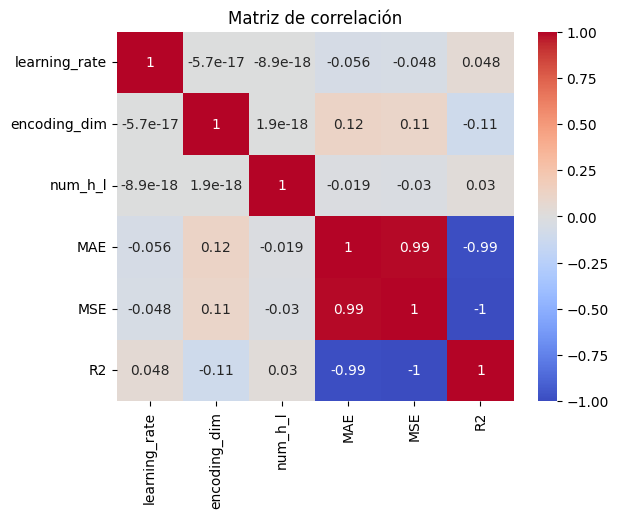

MAE              1.000000
MSE              0.988556
encoding_dim     0.122539
num_h_l         -0.018796
learning_rate   -0.056193
R2              -0.988556
Name: MAE, dtype: float64


In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la correlación entre las columnas
correlation_matrix = df_resultados.corr()

# Visualizar la correlación
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

# Correlación específica con MAE
print(correlation_matrix['MAE'].sort_values(ascending=False))


In [34]:
from sklearn.linear_model import LinearRegression

# Variables independientes y dependiente
X = df_resultados[['learning_rate', 'encoding_dim', 'num_h_l']]
y = df_resultados['MAE']

# Ajustar el modelo
modelo = LinearRegression()
modelo.fit(X, y)

# Coeficientes del modelo
coeficientes = pd.Series(modelo.coef_, index=X.columns)
print("Impacto de las variables en el MAE:")
print(coeficientes.sort_values(ascending=False))


Impacto de las variables en el MAE:
encoding_dim      0.063913
num_h_l          -0.391266
learning_rate   -18.022650
dtype: float64


Importancia de las características según Random Forest:
learning_rate    0.776312
encoding_dim     0.137848
num_h_l          0.085840
dtype: float64


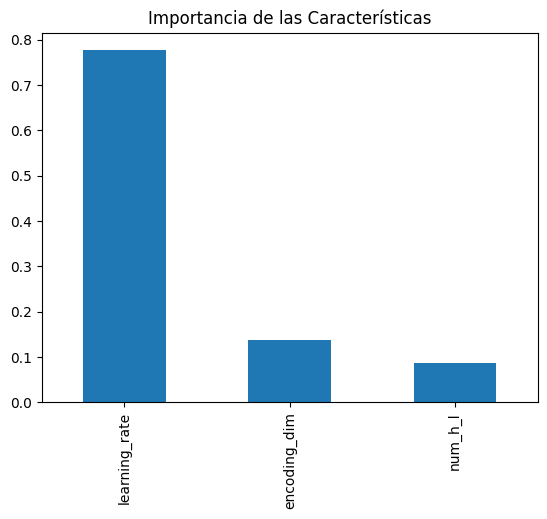

In [35]:
from sklearn.ensemble import RandomForestRegressor

# Crear y ajustar un modelo Random Forest
modelo_rf = RandomForestRegressor(random_state=42)
modelo_rf.fit(X, y)

# Importancia de las características
importancias = pd.Series(modelo_rf.feature_importances_, index=X.columns)
print("Importancia de las características según Random Forest:")
print(importancias.sort_values(ascending=False))

# Visualizar las importancias
importancias.sort_values(ascending=False).plot(kind='bar')
plt.title("Importancia de las Características")
plt.show()


In [36]:
# Crear una nueva interacción manual
df_resultados['dim_hl_interaction'] = df_resultados['encoding_dim'] * df_resultados['num_h_l']

# Evaluar con regresión o modelo de árbol
X = df_resultados[['learning_rate', 'encoding_dim', 'num_h_l', 'dim_hl_interaction']]
modelo_rf.fit(X, y)

# Recalcular las importancias
importancias_interaccion = pd.Series(modelo_rf.feature_importances_, index=X.columns)
print("Importancia con interacciones:")
print(importancias_interaccion.sort_values(ascending=False))


Importancia con interacciones:
learning_rate         0.774109
dim_hl_interaction    0.095162
encoding_dim          0.083814
num_h_l               0.046916
dtype: float64


In [39]:
df_resultados.describe()

,learning_rate,encoding_dim,num_h_l,MAE,MSE,R2,dim_hl_interaction
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.014582,37.333333,1.500000,54.763421,4407.151601,0.183605,56.000000
std,0.032622,20.060260,0.502625,10.462958,1233.313197,0.228463,36.853051
min,0.000010,16.000000,1.000000,39.461349,2610.199238,-0.211204,16.000000
25%,0.000087,16.000000,1.000000,44.952671,3298.824588,-0.018048,32.000000
50%,0.000750,32.000000,1.500000,52.558562,3990.648196,0.260759,48.000000
75%,0.006250,64.000000,2.000000,64.862837,5495.738104,0.388915,64.000000
max,0.100000,64.000000,2.000000,70.928215,6538.451555,0.516478,128.000000


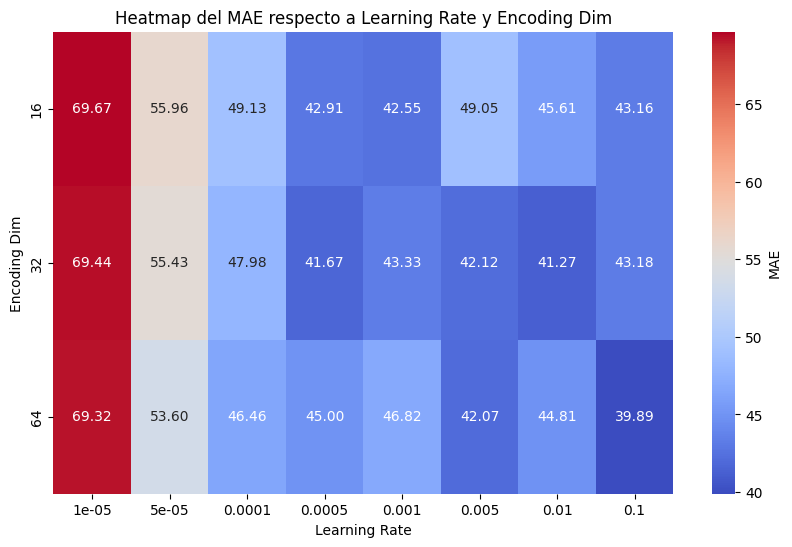

In [41]:
# Ahora puedes ejecutar el código del heatmap
heatmap_data = df_resultados[(df_resultados['kernel'] == 'cos') & (df_resultados['num_h_l'] == 1)].pivot_table(
    index='encoding_dim', 
    columns='learning_rate', 
    values='MAE'
)

# Crear el heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'MAE'})
plt.title("Heatmap del MAE respecto a Learning Rate y Encoding Dim")
plt.xlabel("Learning Rate")
plt.ylabel("Encoding Dim")
plt.show()

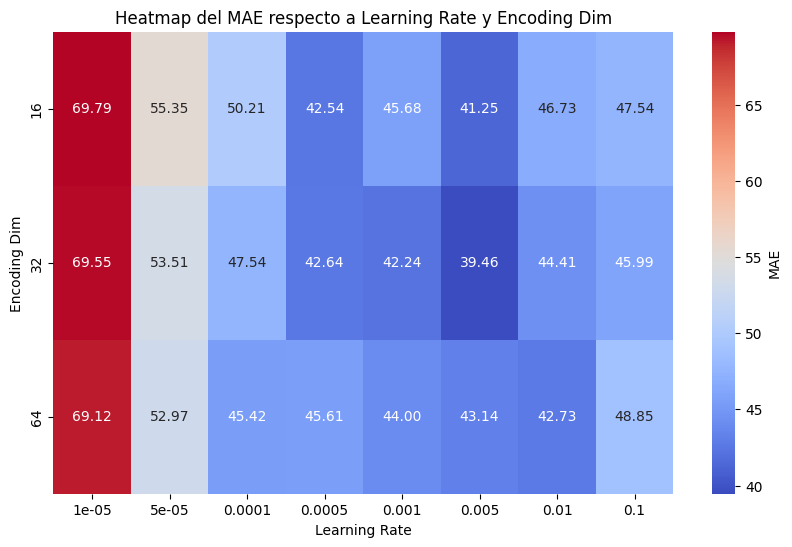

In [42]:
# Ahora puedes ejecutar el código del heatmap
heatmap_data = df_resultados[(df_resultados['kernel'] == 'cos') & (df_resultados['num_h_l'] == 2)].pivot_table(
    index='encoding_dim', 
    columns='learning_rate', 
    values='MAE'
)

# Crear el heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'MAE'})
plt.title("Heatmap del MAE respecto a Learning Rate y Encoding Dim")
plt.xlabel("Learning Rate")
plt.ylabel("Encoding Dim")
plt.show()

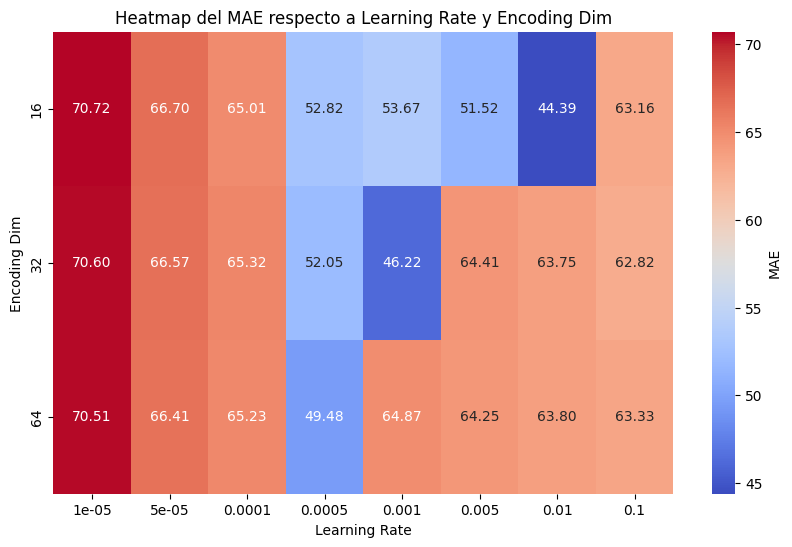

In [43]:
# Ahora puedes ejecutar el código del heatmap
heatmap_data = df_resultados[(df_resultados['kernel'] == 'rbf') & (df_resultados['num_h_l'] == 1)].pivot_table(
    index='encoding_dim', 
    columns='learning_rate', 
    values='MAE'
)

# Crear el heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'MAE'})
plt.title("Heatmap del MAE respecto a Learning Rate y Encoding Dim")
plt.xlabel("Learning Rate")
plt.ylabel("Encoding Dim")
plt.show()

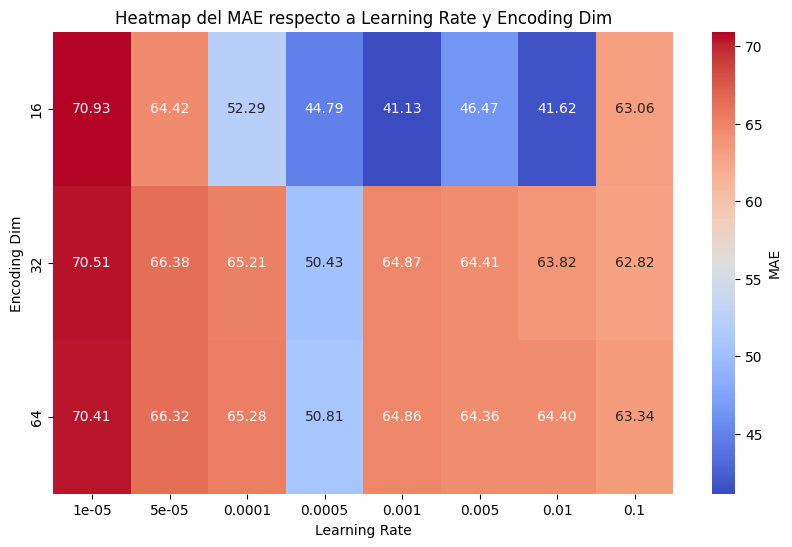

In [44]:
# Ahora puedes ejecutar el código del heatmap
heatmap_data = df_resultados[(df_resultados['kernel'] == 'rbf') & (df_resultados['num_h_l'] == 2)].pivot_table(
    index='encoding_dim', 
    columns='learning_rate', 
    values='MAE'
)

# Crear el heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'MAE'})
plt.title("Heatmap del MAE respecto a Learning Rate y Encoding Dim")
plt.xlabel("Learning Rate")
plt.ylabel("Encoding Dim")
plt.show()

# More Experiments

In [46]:
learning_rates = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1.0]
kernels = ['cos']
encoding_dim = [16, 32, 64, 128]
num_hidden_layers = [1,2]

In [47]:
best_MSE = 2611

for lr, kernel, encoding_dim, num_hidden_layer in itertools.product(learning_rates, kernels, encoding_dim, num_hidden_layers):
    print(f"Running experiment with learning_rate={lr}, kernel={kernel}, encoding_dim={encoding_dim} and num_h_l={num_hidden_layer}")

    stoppping_a = EarlyStopping(
                            monitor="val_loss",
                            min_delta=0,
                            patience=50,
                            verbose=0,
                            mode="min",
                            baseline=None,
                            restore_best_weights=True,
                            start_from_epoch=0,
                        )
    
    kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=True)
    kqm_model.encoder.trainable = True
    
    kqm_model.kqm_class_encoded.compile(
              optimizer=optimizers.Adam(learning_rate=lr),
              loss=losses.mse)
    
    np.random.seed(42)
    indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
    selected_samples = X_train[indices]
    kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
    #kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))
    
    kqm_model.kqm_class_encoded.fit(X_train, y_train,
              validation_split = 0.2,
              epochs=200,
              batch_size=32,
              verbose=0,
              callbacks=[stoppping_a])
    
    y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
    print('MAE =',mean_absolute_error(y_test, y_pred))
    print('MSE =',mean_squared_error(y_test, y_pred))
    print('R^2 =',r2_score(y_test, y_pred))

    if mean_squared_error(y_test, y_pred) < best_MSE:
        best_MSE = mean_squared_error(y_test, y_pred)
        best_model = kqm_model
        best_hyperparameters = (lr, kernel, encoding_dim, num_hidden_layer)
        print("New best model")

print("Best hyper-parameters:", best_hyperparameters)

Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 44.79660229216841
MSE = 3409.6092071034436
R^2 = 0.3683929561822009
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 43.06588865581312
MSE = 3073.5129699533954
R^2 = 0.43065251083801626
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 41.55287004054937
MSE = 2874.8822067323526
R^2 = 0.46744751623275327
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 44.06418001562133
MSE = 3509.3647468350086
R^2 = 0.3499139171700356
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 46.88743774872974
MSE = 3364.31049522314
R^2 = 0.3767842361681495
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 44.75769530561634
MSE = 2938.7417146445537
R^2 = 0.45561797432277307
Running experiment with learning_

```
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 39.174081845391065
MSE = 2578.748222756712
R^2 = 0.5223043337833304
New best model
```